# Exploratory Analysis of Semantic

Install Libraries

In [1]:
%pip install pandas numpy matplotlib seaborn nltk TextBlob torch scikit-learn wordcloud transform --quiet 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from torch.utils.data import DataLoader, Dataset
import torch
# import tensorflow

In [3]:
file_name = os.path.join(os.getcwd(),  'sentiment_analysis.csv')
df = pd.read_csv(file_name)
df = df.drop(columns=['id'])
df.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [4]:
def clean(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    # text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\n',' ', text)  # Remove line breaks
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove punctuation
    text = text.lower()  # Lowercase

    filtered_text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return filtered_text

# Function to extract hashtags from a tweet
def extract_hashtags(tweet):
    hashtags = re.findall(r'#(\w+)', tweet)
    return hashtags

# Apply the function to extract hashtags and create a new column
df['hashtags'] = df['tweet'].apply(extract_hashtags)

df['cleaned_tweet'] = df['tweet'].apply(clean)

# print first lines of dataset to check if clean was okay
# print(df[['tweet', 'cleaned_tweet']].head())

---

Exploring The Dataset - Initial Analysis:

In [5]:
# performing summary statistics

# want to do a 5 number for each 

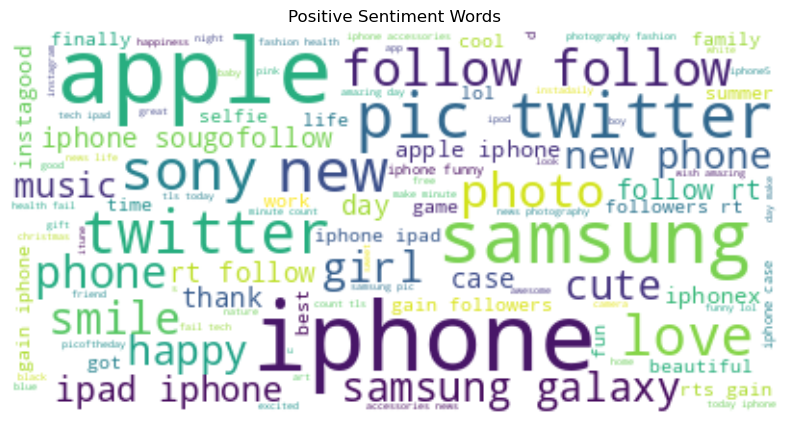

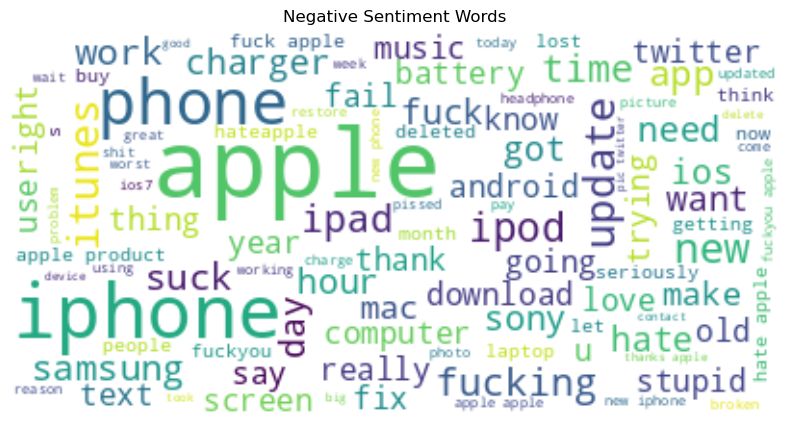

In [6]:
#Word Cloud
from wordcloud import WordCloud

# Generate word clouds
positive_tweets = clean(' '.join(df[df['label'] == 0]['tweet']))
negative_tweets = clean(' '.join(df[df['label'] == 1]['tweet']))

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(positive_tweets)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(negative_tweets)

# Display the positive word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Words')
plt.show()

# Display the negative word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Words')
plt.show()


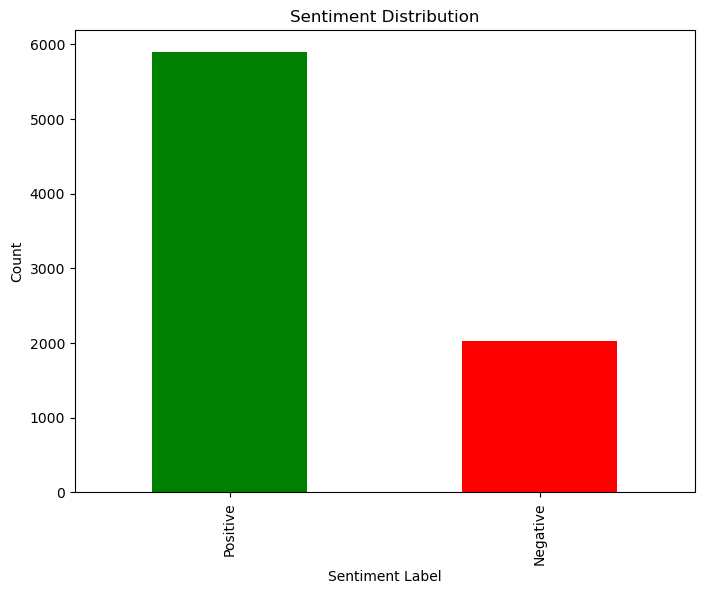

In [7]:
# Bar Chart of sentiment frequencies:
sentiment_counts = df['label'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red'])  # Assuming positive sentiment is labeled as 0 and negative as 1
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Positive', 'Negative'])  # Assuming positive sentiment is labeled as 0 and negative as 1
plt.show()

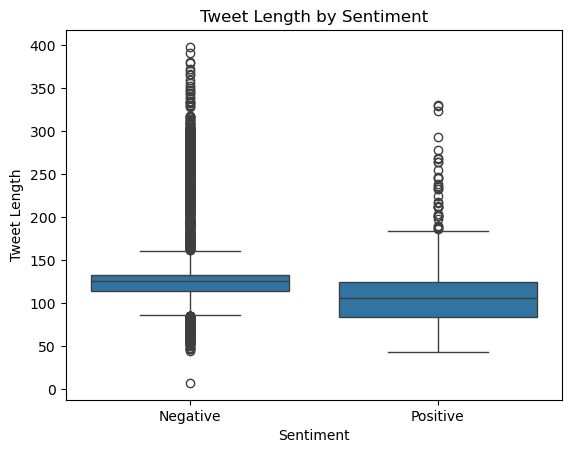

In [8]:
#calculate tweet lengths
df['tweet_length'] = df['tweet'].apply(len)

#plot distribution of tweet length by sentiment
sns.boxplot(x='label', y='tweet_length', data=df)
plt.title('Tweet Length by Sentiment')
plt.xticks([0,1], ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')
plt.show()

<Figure size 1000x600 with 0 Axes>

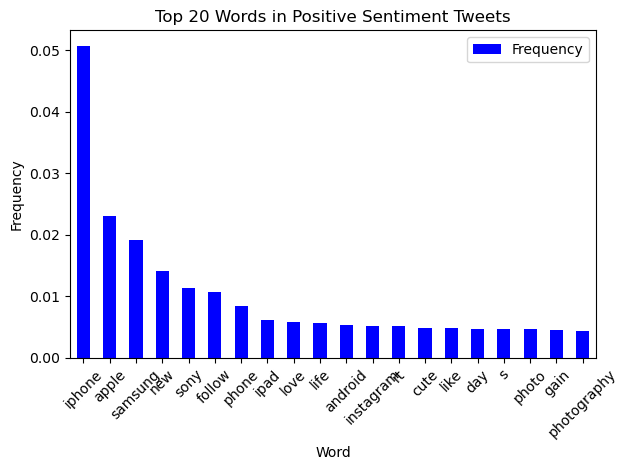

<Figure size 1000x600 with 0 Axes>

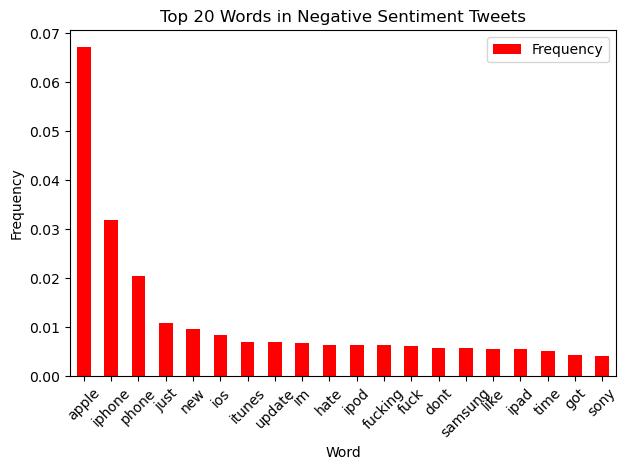

In [9]:
# Word frequency by sentiment:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import ssl

# Download NLTK resources if not already downloaded
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('punkt')

# Assuming your DataFrame is named df

# Tokenize tweets
freq_df = df
freq_df['tokenized_tweets'] = df['cleaned_tweet'].apply(word_tokenize)

# Function to count word frequency for a given sentiment
def count_word_frequency(sentiment_tweets):
    word_freq = Counter()
    for tweet_tokens in sentiment_tweets:
        word_freq.update(tweet_tokens)
    return word_freq

# Separate tweets based on sentiment labels
positive_tweets = freq_df[freq_df['label'] == 0]['tokenized_tweets']
negative_tweets = freq_df[freq_df['label'] == 1]['tokenized_tweets']

# Count word frequency for positive and negative sentiment tweets
positive_word_freq = count_word_frequency(positive_tweets)
negative_word_freq = count_word_frequency(negative_tweets)

# normalize the word frequency
positive_total_words = sum(positive_word_freq.values())
negative_total_words = sum(negative_word_freq.values())

for word in positive_word_freq:
    positive_word_freq[word] /= positive_total_words

for word in negative_word_freq:
    negative_word_freq[word] /= negative_total_words



# Plot word frequency distributions for positive sentiment
plt.figure(figsize=(10, 6))
positive_word_freq_df = pd.DataFrame(positive_word_freq.most_common(20), columns=['Word', 'Frequency'])
positive_word_freq_df.plot(kind='bar', x='Word', y='Frequency', color='blue')
plt.title('Top 20 Words in Positive Sentiment Tweets')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot word frequency distributions for negative sentiment
plt.figure(figsize=(10, 6))
negative_word_freq_df = pd.DataFrame(negative_word_freq.most_common(20), columns=['Word', 'Frequency'])
negative_word_freq_df.plot(kind='bar', x='Word', y='Frequency', color='red')
plt.title('Top 20 Words in Negative Sentiment Tweets')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

# RQ2: Comparing Sentiment Analysis Architectures

In [10]:
# SVM Based approach:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Assuming your DataFrame is named df with columns 'label' and 'tweet'

# Step 1: Split the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Step 2: Feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train = tfidf_vectorizer.fit_transform(train_df['tweet'])
y_train = train_df['label']
X_val = tfidf_vectorizer.transform(val_df['tweet'])
y_val = val_df['label']
X_test = tfidf_vectorizer.transform(test_df['tweet'])
y_test = test_df['label']

# Step 3: Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can try different kernels and hyperparameters
svm_model.fit(X_train, y_train)

# Step 4: Validate the model
y_val_pred = svm_model.predict(X_val)
val_accuracy = (y_val_pred == y_val).mean()
print("Validation Accuracy:", val_accuracy)
print(classification_report(y_val, y_val_pred))

# Step 5: Test the model
y_test_pred = svm_model.predict(X_test)
test_accuracy = (y_test_pred == y_test).mean()
print("Test Accuracy:", test_accuracy)
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.9015151515151515
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       584
           1       0.80      0.84      0.82       208

    accuracy                           0.90       792
   macro avg       0.87      0.88      0.88       792
weighted avg       0.90      0.90      0.90       792

Test Accuracy: 0.8825757575757576
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       568
           1       0.79      0.80      0.79       224

    accuracy                           0.88       792
   macro avg       0.85      0.86      0.86       792
weighted avg       0.88      0.88      0.88       792



LSTM:

In [11]:
#LSTM Code

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        vectorized_text = self.tokenizer.transform([text]).toarray()
        return torch.FloatTensor(vectorized_text), torch.tensor(label)

# Read the data
X = df['tweet'].values
print(X)
y = df['label'].values
print(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

# Define hyperparameters
input_size = len(vectorizer.get_feature_names_out())
hidden_size = 128
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 32

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare data loaders
train_dataset = CustomDataset(X_train, y_train, vectorizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training the model
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

# Prepare the test dataset
test_dataset = CustomDataset(X_test, y_test, vectorizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    # Ensure test_loader is defined as shown above
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float().to(device)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {(correct/total)*100:.2f}%')

['#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'
 'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/'
 'We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu'
 ...
 "Helping my lovely 90 year old neighbor with her iPad this morning has just made me realise that 'I' don't actually need an I pad!"
 'Finally got my #smart #pocket #wifi stay connected anytime,anywhere! #ipad and #samsung #s3 #gadget # http://instagr.am/p/U-53G_vJU8/'
 'Apple Barcelona!!! #Apple #Store #BCN #Barcelona #travel #iphone #selfie #fly #fun #cabincrew… http://instagram.com/p/wBApVzpCl3/']
[0 0 0 ... 0 0 0]


/home/aidan/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/10], Step [100/198], Loss: 0.1192
Epoch [2/10], Step [100/198], Loss: 0.1841
Epoch [3/10], Step [100/198], Loss: 0.0373
Epoch [4/10], Step [100/198], Loss: 0.0104
Epoch [5/10], Step [100/198], Loss: 0.0010
Epoch [6/10], Step [100/198], Loss: 0.0004
Epoch [7/10], Step [100/198], Loss: 0.0007
Epoch [8/10], Step [100/198], Loss: 0.0244
Epoch [9/10], Step [100/198], Loss: 0.0001
Epoch [10/10], Step [100/198], Loss: 0.0002
Accuracy on the test set: 87.06%


BERT:

In [12]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
import numpy as np

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tweet']
        label = self.data.iloc[index]['label']
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define max length and batch size
max_length = 128
batch_size = 16

# Create DataLoader for your dataset
dataset = CustomDataset(df, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
model.eval()
predicted_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels.extend(torch.argmax(probabilities, dim=1).cpu().numpy())

# Convert predicted labels to numpy array
predicted_labels = np.array(predicted_labels)

# Print predicted labels
print(predicted_labels)

# Bert Results:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Example true labels (replace this with your actual true labels)
true_labels = df['label'].values

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 495/495 [00:37<00:00, 13.05it/s]

[0 0 1 ... 1 0 0]
Precision: 0.577758470894874
Recall: 0.3282329713721619
F1-score: 0.4186339313818067
Accuracy: 0.7667929292929293


In [13]:
# Bert Results:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Example true labels (replace this with your actual true labels)
true_labels = df['label'].values

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)


Precision: 0.577758470894874
Recall: 0.3282329713721619
F1-score: 0.4186339313818067
Accuracy: 0.7667929292929293
